In [92]:
import pandas as pd
import pickle
import altair as alt
import pandas as pd
from mpl_toolkits import mplot3d


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt

from helpers import *
from supervised_ensemble import EnsembleObjective, Model


def create_table(data, typ: str = 'mae'):
    datasets = list()
    for model in data:
        df = pd.DataFrame(pd.DataFrame(data[model]).T[typ])
        df.columns = [model]

        datasets.append(df)

    dataset = merge_dataframes(datasets).T
    dataset['Technical Improvement'] = dataset['baseline'] - dataset['technical']
    dataset['Sentiment Improvement'] = dataset['baseline'] - dataset['sentiment']
    dataset['Combined Improvement'] = dataset['baseline'] - dataset['combined']

    return dataset


In [93]:
datasets = dict()
for window in range(2, 7):
    filename = f'pickles/results_{window}.pkl'
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
        datasets[window] = dict()
        for typ in ['mae', 'mse']:
            datasets[window][typ] = create_table(data, typ)

In [94]:
def convert_altair(dataset: pd.DataFrame):
    df = dataset.copy().stack().reset_index()
    df.columns = ['Model', 'Dataset', 'Score']
    df['Score'] = df['Score'].clip(0, 1)
    return df


df = convert_altair(datasets[2]['mae'])
print(df)

     Model                Dataset     Score
0   linear                  dummy  0.681300
1   linear               baseline  0.536120
2   linear              technical  0.433067
3   linear              sentiment  0.519447
4   linear               combined  0.430990
5   linear  Technical Improvement  0.103054
6   linear  Sentiment Improvement  0.016673
7   linear   Combined Improvement  0.105130
8       rf                  dummy  0.681300
9       rf               baseline  0.594096
10      rf              technical  0.466245
11      rf              sentiment  0.514815
12      rf               combined  0.460031
13      rf  Technical Improvement  0.127851
14      rf  Sentiment Improvement  0.079281
15      rf   Combined Improvement  0.134065
16      gb                  dummy  0.681300
17      gb               baseline  0.495833
18      gb              technical  0.434598
19      gb              sentiment  0.489806
20      gb               combined  0.433411
21      gb  Technical Improvemen

In [95]:
offset = 2
dataset_mae = convert_altair(datasets[offset]['mae'][['baseline', 'combined', 'sentiment']])
dataset_mae.columns = [x.title() for x in dataset_mae.columns]
dataset_mae = dataset_mae.rename({"Score": "MAE"}, axis=1)
dataset_mse = convert_altair(datasets[offset]['mse'][['baseline', 'combined', 'sentiment']])
dataset_mse.columns = [x.title() for x in dataset_mse.columns]
dataset_mse = dataset_mse.rename({"Score": "MSE"}, axis=1)
dataset = pd.merge(left=dataset_mse, right=dataset_mae, left_on=['Model', 'Dataset'], right_on=['Model', 'Dataset'])
dataset = pd.melt(dataset, id_vars=['Model','Dataset'], value_vars=['MAE','MSE'], var_name='Measure', value_name='Score')
print(dataset)
cht = alt.Chart(dataset).mark_bar().encode(
    x=alt.X('Model:O', title='', axis=alt.Axis(labelAngle=0)),
    xOffset='Measure',
    y=alt.Y('sum(Score):Q', title='Error',
            scale=alt.Scale(domain=(0, 1), clamp=True)),
    color=alt.Color('Measure:N'),
    column=alt.Column('Dataset:O', title=''),
).properties(
    title='14 Hour Ahead Volatility Accuracy',
)

cht.properties(title='14 Hour Ahead Volatility Accuracy')
cht

     Model    Dataset Measure     Score
0   linear   baseline     MAE  0.536120
1   linear   combined     MAE  0.430990
2   linear  sentiment     MAE  0.519447
3       rf   baseline     MAE  0.594096
4       rf   combined     MAE  0.460031
5       rf  sentiment     MAE  0.514815
6       gb   baseline     MAE  0.495833
7       gb   combined     MAE  0.433411
8       gb  sentiment     MAE  0.489806
9     lgbm   baseline     MAE  0.496042
10    lgbm   combined     MAE  0.439983
11    lgbm  sentiment     MAE  0.492185
12     xgb   baseline     MAE  0.507314
13     xgb   combined     MAE  0.458049
14     xgb  sentiment     MAE  0.507558
15     mlp   baseline     MAE  0.494190
16     mlp   combined     MAE  1.000000
17     mlp  sentiment     MAE  0.486953
18  linear   baseline     MSE  0.766039
19  linear   combined     MSE  0.547841
20  linear  sentiment     MSE  0.729535
21      rf   baseline     MSE  0.907664
22      rf   combined     MSE  0.576359
23      rf  sentiment     MSE  0.696784


alt.Chart(...)

In [56]:
improvement = pd.DataFrame()
for i in range(2, 7):
    df = pd.DataFrame(datasets[i]['mae'][['Sentiment Improvement', 'Technical Improvement', 'Combined Improvement']].iloc[2]).T
    df.index = [i]
    improvement = pd.concat([improvement, df])
print(improvement)

improvement.index.name = "Days Ahead"
improvement = improvement.reset_index()
cht_1 = alt.Chart(improvement).mark_point().encode(
    x=alt.X("Days Ahead").scale(domain=(1, 7)),
    y=alt.Y(
        alt.repeat("layer"), aggregate="mean", title="MAE decrease"
    ),
    color=alt.datum(alt.repeat("layer")),
).repeat(layer=["Sentiment Improvement", "Technical Improvement", "Combined Improvement"]).properties(title='Model Performance Improvement Relative to Baseline').configure_axis(
    grid=False
)
cht_1

   Sentiment Improvement  Technical Improvement  Combined Improvement
2               0.006027               0.061235              0.062422
3               0.005730               0.064340              0.065537
4               0.006171               0.071729              0.072853
5               0.007728               0.072226              0.072909
6               0.007530               0.080128              0.081648
   Sentiment Improvement  Technical Improvement  Combined Improvement
2               0.006027               0.061235              0.062422
3               0.005730               0.064340              0.065537
4               0.006171               0.071729              0.072853
5               0.007728               0.072226              0.072909
6               0.007530               0.080128              0.081648


alt.RepeatChart(...)

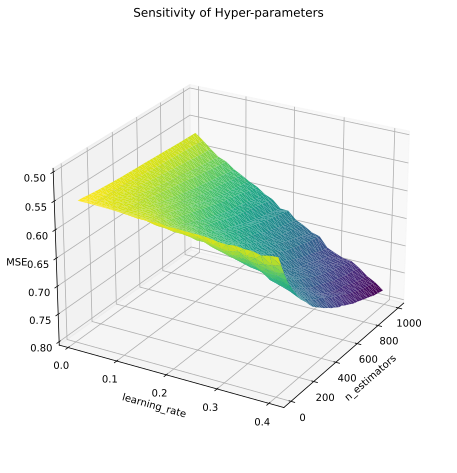

In [105]:
df = pd.read_csv('hyper.csv')
fig = plt.figure(figsize=(8, 8))

x = df['n_estimators']
y = df['learning_rate']
z = df['score']

ax = plt.axes(projection='3d');
ax.plot_trisurf(x, y, z,
                cmap=plt.cm.get_cmap('viridis').reversed(), edgecolor='none');
ax.set_title('Sensitivity of Hyper-parameters');

ax.set_xlabel('n_estimators');
ax.set_ylabel('learning_rate');
ax.set_zlabel('MSE');
ax.set_zlim(0.5,0.8);
ax.invert_zaxis();
ax.invert_xaxis();
ax.view_init(elev=25, azim=30, roll=0);
ax.set_box_aspect(aspect=None, zoom=0.9);
start, end = ax.get_ylim();
ax.yaxis.set_ticks([0,0.1,0.2,0.3,0.4]);
plt.show()

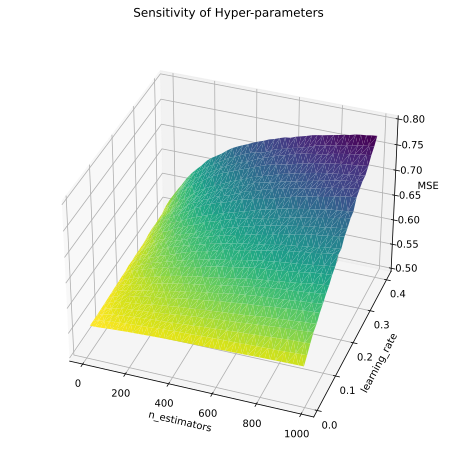

In [112]:
fig = plt.figure(figsize=(8, 8))

ax = plt.axes(projection='3d');
ax.plot_trisurf(x, y, z,
                cmap=plt.cm.get_cmap('viridis').reversed(), edgecolor='none');
ax.set_title('Sensitivity of Hyper-parameters');

ax.set_xlabel('n_estimators');
ax.set_ylabel('learning_rate');
ax.set_zlabel('MSE');
ax.set_zlim(0.5,0.8);
ax.view_init(elev=35, azim=-70, roll=0);
ax.set_box_aspect(aspect=None, zoom=0.9);
start, end = ax.get_ylim();
ax.yaxis.set_ticks([0,0.1,0.2,0.3,0.4]);
plt.show()